In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,7)

## Step 0
### Data Acquisition

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"]  # type: ignore

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005931,-0.002103,0.004750,0.007326,0.003524,0.004447,0.003478
2017-01-05,-0.000795,-0.002503,-0.003084,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003572,0.000922,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003307,-0.014601,-0.028410,0.003122,0.008199,0.002840,-0.000203
2017-01-10,0.000000,-0.009133,0.000000,0.007099,0.004251,0.000324,0.000203
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021226
2021-12-28,-0.000817,-0.000713,-0.008699,-0.007690,-0.004319,-0.008060,-0.005222
2021-12-29,0.001278,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 1
### Foundational Analysis, part C: identify volatility regimes in SPY using a Markov Switching AutoRegressive (MS-AR) model

For starters, we inspect the statistical properties of SPY returns for the 2017-22 timeframe and then plot the series on a graph.

In [3]:
print("Main statistical features of the time series for daily SPY returns, 2017-22:")
print(rets["SPY"].describe())

Main statistical features of the time series for daily SPY returns, 2017-22:
count    1258.000000
mean        0.000663
std         0.011944
min        -0.115886
25%        -0.002942
50%         0.000920
75%         0.005883
max         0.086731
Name: SPY, dtype: float64


In [4]:
plt.rcParams["figure.figsize"] = (12,7)

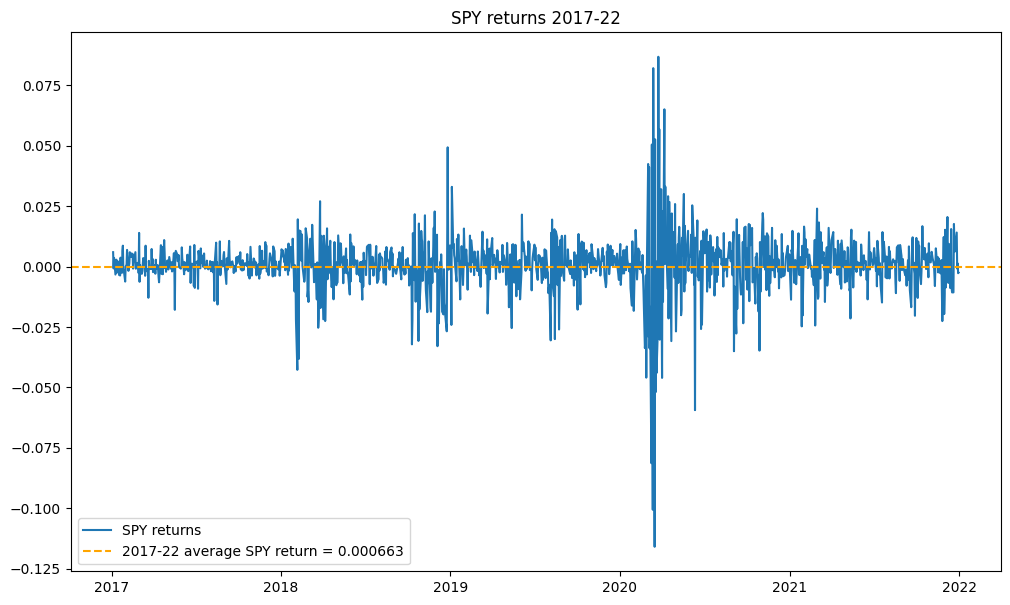

In [5]:
plt.plot(rets["SPY"], label="SPY returns")
plt.axhline(0, ls="--", color="orange", lw=1.5, label="2017-22 average SPY return = 0.000663")
plt.legend(loc="lower left")
plt.title("SPY returns 2017-22")

plt.show()

We can see from the graph above that the SPY time series is stationary and thus mean-reverting, with variable volatility appearing in persistent regimes.
The time series is heteroscedastic: bouts of high volatility tend to keep going for a while, before subsuming.

We expect that a Markov Switching Auto-Regressive (MS-AR) model could be fit to the data with some success.
Exploiting the heteroscedasticity of the SPY series, the model will be switching between a low volatility *calm* regime, and a high volatility *stressed* regime.
For simplicity, the autoregression of the model will be of order 1, with the current observation $y_t$ dependent solely on the previous one $y_{t-1}$:

$$
y_t = \mu_{S_t} + \phi (y_{t_1} - \mu_{S_{t-1}}) + \varepsilon_t
$$

with $S_t = \{1, 2\}$ being the Markov regime at time $t$, $\mu_{S_t}$ being the average value of all $y$ falling under regime $S_t$ up to instant $t$, $\phi (\text{drift})$ being the peculiar expression of mean reversion for the particular model adopted, and $\varepsilon$ being the associated normal error.

$S_t$ switches between calm and stressed regimes according to a transition matrix:

$$
P(S_t | S_{t-1}) = \begin{bmatrix}
    p_{00} & p_{01}\\
	p_{10} & p_{11}
\end{bmatrix}
$$

where $p_{ij}$ is the probability for $y_t$ of switching from regime $S_{t-1} = i$ to regime $S_t = j$.

The mean-reverting and volatility-clustering properties of the SPY returns lends itself to be represented by an Ornstein-Uhlenbeck (OU) process, which mathematical expression is

$$
d y_t = \kappa (\mu - y_t) dt + \sigma dW_t
$$

where $\kappa$ is the speed of the mean reversion and $\sigma$ is the volatility of the Wiener process $d W_t$.
A solution for the UO process above exists in closed form, and after being discretised in temporal steps of length $\Delta t$, it takes the following form:

$$
y_{t + \Delta t} = \mu + (y_t - \mu) e^{- \kappa \Delta t} + \varepsilon_{t + \Delta t}
$$

with error $\varepsilon$ normally distributed:

$$
\varepsilon_{t + \Delta t} \sim N \left( 0, \frac{\sigma^2}{2 \kappa} (1 - e^{- 2 \kappa \Delta t}) \right)
$$

There is an out-of-the-box rendition of a MS-AR model within the *statsmodels* package for python, the `MarkovAutoregression` class.

In [6]:
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

We set the `MarkovAutoregression` object to follow a simple AR(1) process

$$
y_t = \alpha + \beta y_{t-1} + \varepsilon_t
$$

where we need to calibrate coefficient $\beta$ according to the parameters in our UO process for SPY returns.

Comparing formulas for the generic UO and AR(1) processes, it follows that

\begin{aligned}
\alpha =& \mu (1 - e^{- \kappa \Delta t}) = \mu (1 - \beta)\\
\beta =& e^{- \kappa \Delta t}
\end{aligned}

We start from inferring a very rough and qualitative estimation for the half-time of mean-reversion $\tau_{1/2}$, from the graph of SPY returns.

$$
\tau_{1/2} = \frac{\log{2}}{\kappa}
$$

with $\kappa$ being the reversion speed parameter in the UO process.

We set 

| (days) | calm regime | stressed regime |
|:---:|:---:|:--:|
| $\tau_{1/2}$ | 10.5 | 21 |

It is easy to extract $\kappa$ from the expression of $\tau_{1/2}$.

Since we have daily data for SPY, our $\Delta t = \frac{1}{252}$, expressed in terms of a business year.

Knowing $\Delta t$ and $\kappa$ for both regimes allows us to determine starting values for $\beta$ and $alpha$, to be fed to the `MarkovAutoregression` object.

This object also needs starting values for the volatility $\sigma$ and unconstrained probabilities of transition $p$ for both Markov regimes considered.
While the former can be estimated visually, the latter is prescribed by *statsmodels* to follow an inverse logit form:

$$
\text{logit}(p) = \frac{e^p}{1 + e^p}
$$

We choose probability to persist in the same regime $p = [0.9, 0.5]$ for calm and stressed regime, respectively.
We feed the model the $\text{logit}(p)$ values according to the above-mentioned formula.

In [7]:
# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

In [ ]:
# a = dict({"logit" : logit, "alpha" : alpha, "sigma" : sigma, "beta" : beta})
# a

{'logit': array([0.7109495 , 0.62245933]),
 'alpha': array([ 3.19411288e-05, -3.24682215e-05]),
 'sigma': [0.008, 0.02],
 'beta': array([0.93611774, 0.96753178])}

Thus we can list below the numerical starting values for the parameters within the `MarkovAutoregression` object:

| starting value | calm regime | stressed regime |
|:---:|:---:|:--:|
| $\text{logit}(p)$ | 0.711 | 0.622 |
| $\alpha$ | 3.19e-5 | -3.25e-5 |
| $\sigma$ | 0.008 | 0.02 |
| $\beta$ | 0.936 | 0.968 |

The `MarkovAutoregression` object also accepts boundary values not to trespass during the analysis.

We think the following are realistic constraints:

| bounds | lower | upper |
|:---:|:---:|:--:|
| $\text{logit}(p)$ | 0.25 | 0.931 |
| $\alpha$ | -0.001 | 0.1 |
| $\sigma$ | 0.001 | $\infty$ |
| $\beta$ | 0.5 | 1.3 |

In [16]:
# parameter layout:
#  0,1   → alpha_0, alpha_1          (intercepts)
#  2,3   → phi_0, phi_1          (AR(1) beta's)
#  4,5   → sigma_0, sigma_1        (variances)
#  6,7   → unconstrained elements of P (logit‑scale)

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20) # bounds=b,

In [17]:
print( spy_markov_results.summary() )

                         Markov Switching Model Results                         
Dep. Variable:                      SPY   No. Observations:                 1257
Model:             MarkovAutoregression   Log Likelihood                4238.063
Date:                  Thu, 18 Sep 2025   AIC                          -8460.127
Time:                          03:17:12   BIC                          -8419.035
Sample:                               0   HQIC                         -8444.683
                                 - 1257                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.255      0.210      -0.003       0.001
sigma2         0.0004   3.91e-05    

The simulation results above indicate that while transition probabilities estimations might be reliable, coefficient $\alpha$ for the stressed regime, and $\beta$ for the calm regime are given with non-negligible incertitude.

Below, the parameters for the MS-AR model as computed inside the `MarkovAutoregression` object; *const* stands for $\alpha$, and *ar.L1* for $\beta$.

In [18]:
spy_markov_results.params

p[0->0]      0.936022
p[1->0]      0.023229
const[0]    -0.001159
const[1]     0.001359
sigma2[0]    0.000416
sigma2[1]    0.000029
ar.L1[0]    -0.261290
ar.L1[1]    -0.046086
dtype: float64

In the following, we plot the probabilities of being in either regime.

We can tell the bout of high volatility due to the Covid pandemic from March 2020 through most of the year is correctly estimated, included a brief recovery during a relatively disease-free summer '20.

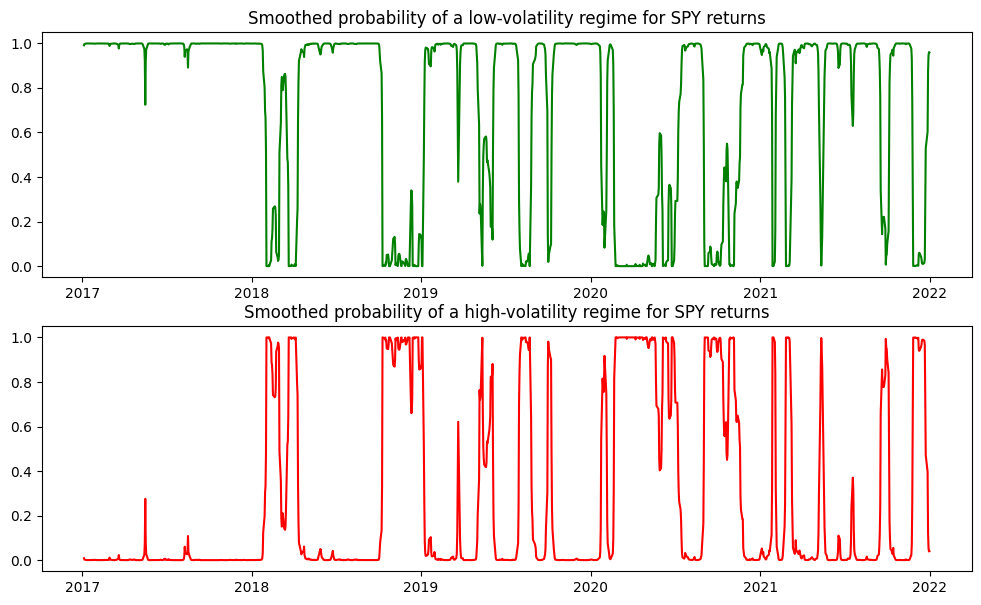

In [ ]:
fig, axes = plt.subplots(2)

ax = axes[0]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
ax.set(title="Probability of a low-volatility regime for SPY returns")

ax = axes[1]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[0],'r')
ax.set(title="Probability of a high-volatility regime for SPY returns")
plt.show()

In [20]:
print("Average duration of each regime:")
print(f"Calm regime: {spy_markov_results.expected_durations[1]:.3f}  days\nStressed regime:  {spy_markov_results.expected_durations[0]:.3f} days")

Average duration of each regime:
Calm regime: 43.050  days
Stressed regime:  15.630 days


Average duration for the calm regime being nearly three times that of the stressed regime, this confirms our expectations.

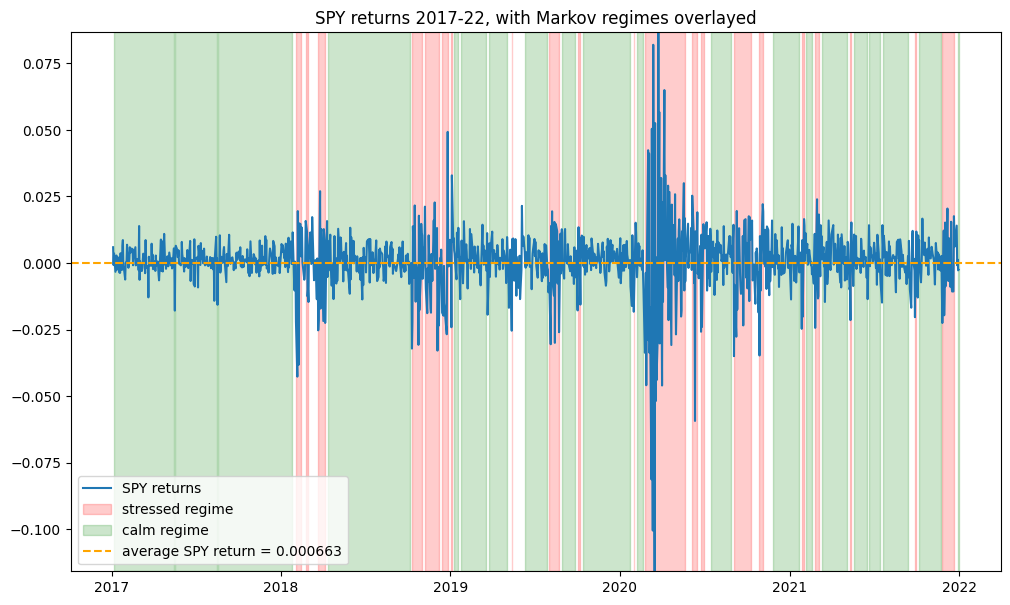

In [ ]:
min_spy = np.min(rets["SPY"])
max_spy = np.max(rets["SPY"])
overlay = spy_markov_results.smoothed_marginal_probabilities[0] #* max_spy
overlay_g = spy_markov_results.smoothed_marginal_probabilities[1]

plt.plot(rets["SPY"], label="SPY returns")
plt.fill_between(overlay.index, min_spy, max_spy, where=overlay.values > 0.9, color="r", alpha=0.2, label="stressed regime")
plt.fill_between(overlay_g.index, min_spy, max_spy, where=overlay_g.values > 0.9, color="g", alpha=0.2, label="calm regime")
plt.axhline(0, ls="--", color="orange", lw=1.5, label="average SPY return = 0.000663")

plt.ylim(min_spy, max_spy)
plt.legend(loc="lower left")
plt.title("SPY returns 2017-22, with Markov regimes overlayed")

plt.show()

In the graph above, we overlay the Markov regimes on the SPY returns.

It can clearly be seen that the MS-AR model - as calibrated throughout this section - is successful in assigning the many periods of volatility clustering recorded during years 2017-22 to the correct regime.